Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.layers import GlobalAveragePooling2D
from keras.utils import np_utils
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import callbacks

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input, decode_predictions
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions

from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array, load_img


Using TensorFlow backend.


Loading data and splitting into Train and Test datasets

In [2]:
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

X_train.shape, y_train.shape

((60000, 28, 28), (60000,))

Extracting unique values of labels

In [3]:
np.unique(y_train)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [0]:
labels   = {0 : 'T-shirt/top',
            1 : 'Trouser',
            2 : 'Pullover',
            3 : 'Dress',
            4 : 'Coat',
            5 : 'Sandal',
            6 : 'Shirt',
            7 : 'Sneaker',
            8 : 'Bag',
            9 : 'Ankle boot'}

plotting a figure of feature

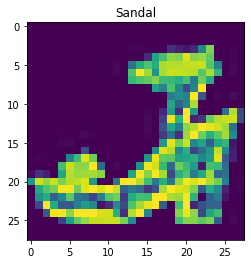

In [5]:
plt.figure(figsize=(6,4))
plt.imshow(X_train[60])
plt.title(labels[y_train[60]])
plt.show()

Reshaping of Features for inputs

In [6]:
X_train = X_train.reshape(X_train.shape[0],28,28,1)
X_test = X_test.reshape(X_test.shape[0],28,28,1)

X_train.shape, X_test.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

Converting Channel 1 to Channel 3

In [7]:
X_train = np.repeat(X_train,3,-1)
X_test = np.repeat(X_test,3,-1)

X_train.shape, X_test.shape

((60000, 28, 28, 3), (10000, 28, 28, 3))

Normalization of features

In [0]:
X_train = X_train.astype('float32')/255
X_test = X_test.astype('float32')/255

Converting labels into Binary form

In [9]:
y_train = np_utils.to_categorical(y_train.astype('float32'),num_classes=10)
y_test = np_utils.to_categorical(y_test.astype('float32'),num_classes=10)

y_train[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.], dtype=float32)

In [10]:
# Resize the images as 48 * 48 as required by ResNet50
from keras.preprocessing.image import img_to_array, array_to_img

X_train = np.asarray([img_to_array(array_to_img(im, scale=False).resize((48,48))) for im in X_train])
X_test = np.asarray([img_to_array(array_to_img(im, scale=False).resize((48,48))) for im in X_test])

# Display the new shape
X_train.shape, X_test.shape

((60000, 48, 48, 3), (10000, 48, 48, 3))

In [11]:
# Here I split original training data to sub-training (80%) and validation data (20%)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=13)

# Check the data size whether it is as per tensorflow and ResNet50 requirement
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((48000, 48, 48, 3), (12000, 48, 48, 3), (48000, 10), (12000, 10))

In [12]:
X_test.shape, y_test.shape 

((10000, 48, 48, 3), (10000, 10))

Building model

In [13]:
# Create the base model of ResNet50
model = ResNet50(weights='imagenet', include_top=False, input_shape = (48,48,3))
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 48, 48, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 54, 54, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 24, 24, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 24, 24, 64)   256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [0]:
# Preprocessing the input 
X_train = preprocess_input(X_train)
X_val = preprocess_input(X_val)
X_test = preprocess_input(X_test)

In [0]:
#Adding Fully connected layers

x=model.output                                                          
x=GlobalAveragePooling2D()(x)                                                
x=Dense(1024,activation='relu')(x)                                           
x=Dense(1024,activation='relu')(x)                                           
x=Dense(512,activation='relu')(x)        

predictions=Dense(10,activation='softmax')(x)                                      
model=Model(inputs=model.input,outputs=predictions) 

In [0]:
#compiling the model

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:

# Incorporating reduced learning and early stopping for callback

reduce_learning = callbacks.ReduceLROnPlateau(monitor='val_loss',
                                              factor=0.2,
                                              patience=2,
                                              mode='auto',
                                              min_delta=0.0001,
                                              min_lr=0)

early_stopping = callbacks.EarlyStopping(monitor='val_loss',
                                         min_delta=0,
                                         patience=4,
                                         verbose=1,
                                         mode='auto')

callbacks = [reduce_learning, early_stopping]


In [0]:
#Image data generator
datagen = ImageDataGenerator(rotation_range=30,
                             width_shift_range=0.2,
                             height_shift_range=0.23,
                             horizontal_flip=True,
                             vertical_flip=True,
                             zoom_range=0.2)

In [0]:
batch_size = 256
epochs = 50

batches = datagen.flow(X_train, y_train, batch_size=batch_size)
val_batches = datagen.flow(X_val, y_val, batch_size=batch_size)

In [20]:
history = model.fit(batches, steps_per_epoch=X_train.shape[0]//batch_size, epochs=epochs, validation_data=val_batches,
                    validation_steps=X_val.shape[0]//batch_size, callbacks=callbacks)
history

Epoch 1/50
187/187 [==============================] - 51s 275ms/step - loss: 2.2536 - accuracy: 0.1419 - val_loss: 67.7310 - val_accuracy: 0.1013 - lr: 0.0010
Epoch 2/50
187/187 [==============================] - 50s 269ms/step - loss: 2.2161 - accuracy: 0.1534 - val_loss: 9.5268 - val_accuracy: 0.1011 - lr: 0.0010
Epoch 3/50
187/187 [==============================] - 50s 267ms/step - loss: 2.2057 - accuracy: 0.1592 - val_loss: 3.8897 - val_accuracy: 0.1015 - lr: 0.0010
Epoch 4/50
187/187 [==============================] - 50s 266ms/step - loss: 2.1997 - accuracy: 0.1629 - val_loss: 4.5179 - val_accuracy: 0.1012 - lr: 0.0010
Epoch 5/50
187/187 [==============================] - 50s 266ms/step - loss: 2.1987 - accuracy: 0.1621 - val_loss: 2.4463 - val_accuracy: 0.0993 - lr: 0.0010
Epoch 6/50
187/187 [==============================] - 50s 266ms/step - loss: 2.1982 - accuracy: 0.1591 - val_loss: 4.6983 - val_accuracy: 0.1022 - lr: 0.0010
Epoch 7/50
187/187 [==============================]

In [0]:
model.save("/content/drive/My Drive/FMNIST/fashion_mnist_resnet50_check.h5")

Evaluating with Test dataset

In [0]:
#loading trained model
check = load_model("/content/drive/My Drive/FMNIST/fashion_mnist_resnet50_check.h5")

In [30]:
#predicting with test features
y_pred = check.predict(X_test, batch_size=256, verbose=1)
y_pred[0]

40/40 [==============================] - 1s 37ms/step


array([0.000000e+00, 1.000000e+00, 0.000000e+00, 3.292169e-24,
       0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
       0.000000e+00, 0.000000e+00], dtype=float32)

In [32]:
#finding classes of predicted labels
y_pred_cls = np.argmax(y_pred,axis=1)
y_pred_cls

array([1, 1, 1, ..., 1, 1, 1])

In [36]:
y_test.shape, y_pred.shape

((10000, 10), (10000, 10))

In [37]:
#finding classes of test labels
y_test_cls = np.argmax(y_test, axis=1)
y_test_cls

array([9, 2, 1, ..., 8, 1, 5])

In [39]:
#Confusion Matrix
confusion_matrix(y_test_cls, y_pred_cls)

array([[   0, 1000,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0, 1000,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0, 1000,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0, 1000,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0, 1000,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0, 1000,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0, 1000,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0, 1000,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0, 1000,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0, 1000,    0,    0,    0,    0,    0,    0,    0,    0]])